Вариационная модель звезды

Как параметр задана масса звезды M.
Звезда разбита на N сферических слоев.
Также задано распределение водорода по слоям.
Имеется N+1 точка - расстояния от центра до i-го слоя.
Неизвестными являются массивы расстояний r[i] и температур t[i]

Date of creation: 2.07.2020

Last updated: 3.07.2020

In [39]:
import math
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

In [40]:
import physics as ph

In [41]:
from Sun import SSM18 as s

In [42]:
pi = math.pi
# K = 6 # number of interpolated layers
# dimM = 17*K+1 # N+1 - число точек модели (сферических слоев + 1)
Z = s.Z

In [43]:
# df1 = s.load_interpolated_data(K)
def load_model(epoch):
#     filename = 'FromCenter/1epoch%.02d.csv' % epoch
    filename = 'Mass/1epoch%.02d.csv' % epoch
    return pd.read_csv(filename)
epoch = 0
df1 = load_model(epoch)
dimM = len(df1.index)
df1

,Unnamed: 0,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Convection,Pressure,Velocity
0,0,0.000000e+00,0.000000e+00,1.333000e+07,94.554471,0.000000e+00,0.732,1.318613,0.0,1.730205e+17,8.561869e-11
1,1,1.989737e+30,1.720827e+09,1.323295e+07,93.267398,2.371017e+31,0.732,1.337635,0.0,1.694228e+17,8.186134e-11
2,2,3.979475e+30,2.170742e+09,1.317560e+07,92.506463,4.667612e+31,0.732,1.348390,0.0,1.673123e+17,7.971258e-11
3,3,5.969212e+30,2.487796e+09,1.312752e+07,91.867973,6.909218e+31,0.732,1.357124,0.0,1.655511e+17,7.795029e-11
4,4,7.958950e+30,2.741213e+09,1.308464e+07,91.297969,9.104061e+31,0.732,1.364692,0.0,1.639865e+17,7.640787e-11
...,...,...,...,...,...,...,...,...,...,...,...
996,996,1.981778e+33,5.478443e+10,8.884676e+05,0.065450,2.461129e+33,0.732,6.506261,1.0,7.982444e+12,2.801593e-22
997,997,1.983768e+33,5.565851e+10,7.779882e+05,0.053620,2.461129e+33,0.732,5.330260,1.0,5.726433e+12,5.617357e-23
998,998,1.985758e+33,5.672587e+10,6.475668e+05,0.040707,2.461129e+33,0.732,4.046600,1.0,3.618575e+12,6.097868e-24
999,999,1.987748e+33,5.818398e+10,4.769614e+05,0.025719,2.461129e+33,0.732,2.556699,1.0,1.683936e+12,1.506867e-25


In [169]:
x = df1['Hydrogen'].values
m = df1['Mass'].values
d = df1['Density'].values
t = df1['Temperature'].values
# The rest may be computed from the above variables.
# r = df1['Radius'].values
# l = df1['Luminosity'].values
# p = df1['Pressure'].values
# k = df1['Opacity'].values
c = df1['Convection'].values
# v = df1['Velocity'].values

In [171]:
r = np.zeros(dimM)
l = np.zeros(dimM)
p = np.zeros(dimM)
k = np.zeros(dimM)
# c = np.zeros(dimM)
v = np.zeros(dimM)

In [197]:
# Вычисляем величины r,l,p,k,c,v из x,m,d,t
r[0] = 0.
l[0] = 0.
for i in range(1, dimM):
    r[i] = pow(pow(r[i-1], 3) + 3*(m[i] - m[i-1])/4/pi/d[i-1], 1/3) 
    l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(0.5*(d[i]+d[i-1]), 0.5*(t[i]+t[i-1]), x[i], 1 - Z - x[i], Z)
for i in range(dimM):
    X = x[i]
    Y = 1 - Z -X
    p[i] = ph.Pressure(d[i], t[i], X, Y, Z)
    k[i] = ph.opacity(d[i], t[i], X, Y, Z)
    v[i] = 4*ph.m_prot*ph.Etot(d[i], t[i], X, Y, Z)/X/ph.dEpp*ph.year

In [179]:
# Вычисляем новые содержание водорода через 1 млрд лет.
x1 = x*np.exp(-1e9*v)
x1

array([0.67193514, 0.67446459, 0.67591541, ..., 0.732     , 0.732     ,
       0.732     ])

In [180]:
x = x1

In [196]:
t *= 1.01

In [150]:
e = np.zeros(dimM) # энерговыделения
a = np.zeros(dimM) # градиент давления
da = np.zeros(dimM) # несоответствие градиента давления
b = np.zeros(dimM) # градиент температуры
br = np.zeros(dimM) # градиент температуры при радиации
bc = np.zeros(dimM) # градиент температуры при конвекции
db = np.zeros(dimM) # несоответствие градиента температуры 

Уравнение массы - находим радиусы как функцию плотности

In [151]:
# for i in range(1, dimM-1):
#     d1[i] = 3/4/pi*(m[i+1] - m[i-1])/(pow(r[i+1], 3) - pow(r[i-1], 3))
#     print(i, d[i], d1[i], pow((d1[i] - d[i])/d[i], 2))

Условие гидростатики

In [198]:
for i in range(1, dimM-1):
    mu = ph.MU(x[i], 1 - x[i] -Z, Z)
    a[i] = -ph.G*m[i]*d[i]/pow(r[i], 2)
    da[i] = (p[i+1] - p[i])/2/(r[i+1] - r[i]) + (p[i] - p[i-1])/2/(r[i] - r[i-1]) #- a[i]
#     print(i, a[i], da[i], pow((a[i] - da[i])/a[i], 2))

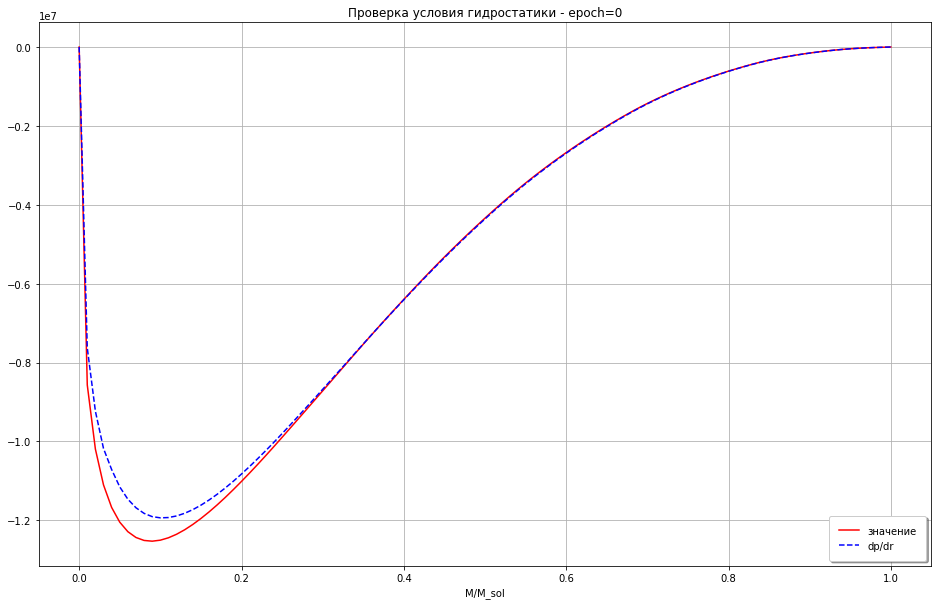

In [199]:
r1 = r[::10]/s.R
m1 = m[::10]/s.M
a1 = a[::10]
da1 = da[::10]
plt.figure(figsize=(16, 10))
ax = plt.axes()
plt.plot(m1, a1, color='red', label='значение')
plt.plot(m1, da1, '--', color='blue', label='dp/dr')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Проверка условия гидростатики - epoch=%d' % epoch)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

Условие переноса энергии

In [200]:
for i in range(1, dimM-1):
    br[i] = -3/16*k[i]*d[i]*l[i]/ph.sigma/pow(t[i], 3)/4/pi/pow(r[i], 2)
    mu = ph.MU(x[i], 1 - x[i] -Z, Z)
    bc[i] = -0.4*mu/ph.kB*ph.m_prot*ph.G*m[i]/pow(r[i], 2)
    if abs(br[i]) < abs(bc[i]):
        b[i] = br[i]
    else:
        b[i] = bc[i]
    db[i] = (t[i+1] - t[i])/2/(r[i+1] - r[i]) + (t[i] - t[i-1])/2/(r[i] - r[i-1]) # - b[i]
#     print(i, b[i], db[i], pow((b[i] - db[i])/b[i], 2))

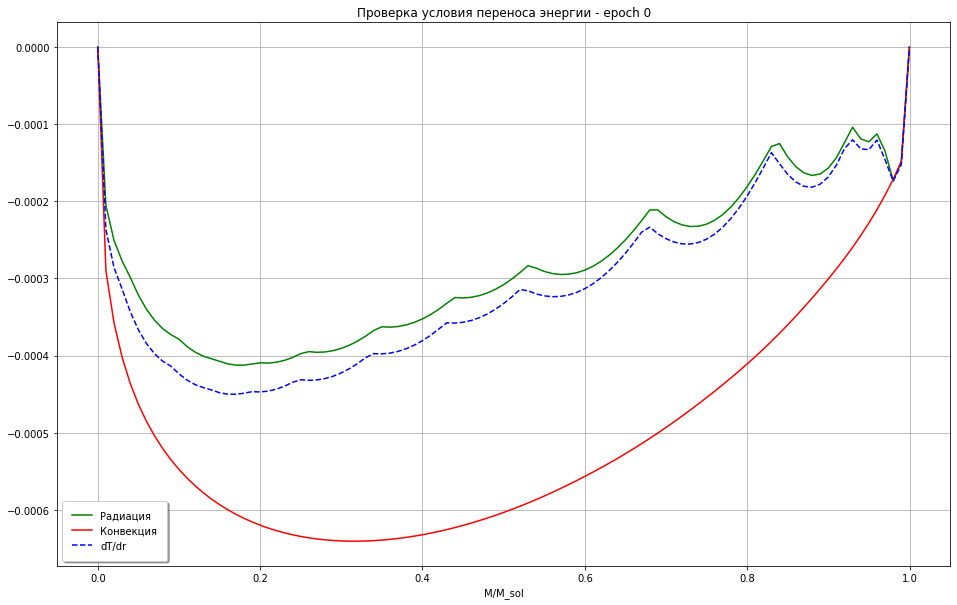

In [201]:
m1 = m[::10]/s.M
r1 = r[::10]/s.R
b1 = br[::10]
b2 = bc[::10]
db1 = db[::10]
plt.figure(figsize=(16, 10))
ax = plt.axes()
plt.plot(m1, b1, color='green', label='Радиация')
plt.plot(m1, b2, color='red', label='Конвекция')
plt.plot(m1, db1, '--', color='blue', label='dT/dr')
# plt.xlim(0,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Проверка условия переноса энергии - epoch %d' % epoch)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

In [202]:
sa = 0
sb = 0
for i in range(1, dimM-1):
    sa += pow((da[i] - a[i])/a[i], 2)
    sb += pow((db[i] - b[i])/b[i], 2)
sa, sb    

(0.9083740411486991, 10.104433837309749)

In [189]:
# (1.028809394773563, 7.761221355954376)
# (1.028809394773563, 3.090175282114637) - d * 1.01
# (0.9083740411486991, 10.104433837309749) d* 1.01 + t * 1.01

(1.028809394773563, 7.761221355954376)

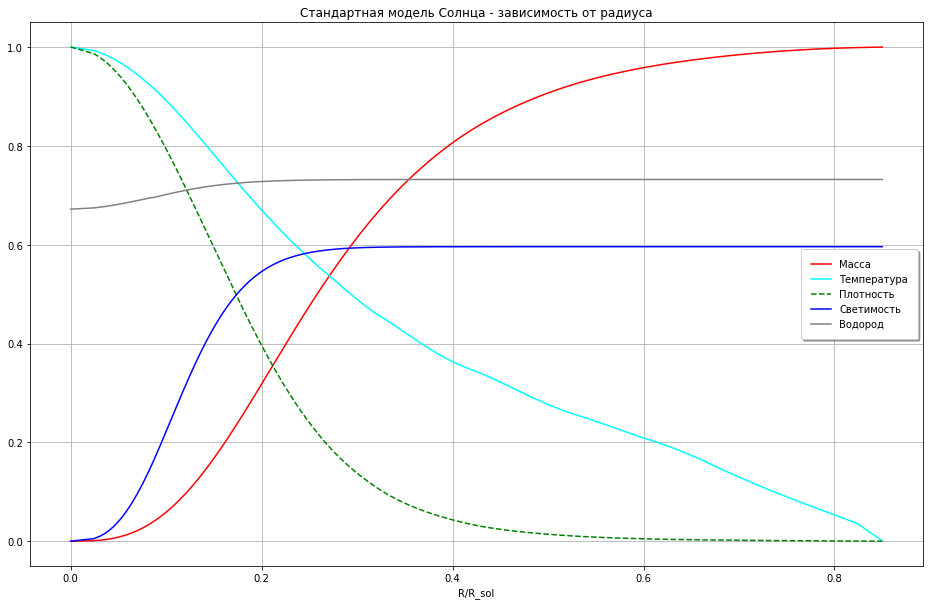

In [187]:
r1 = r/s.R
plt.figure(figsize=(16, 10))
ax = plt.axes()
plt.plot(r1, m/s.M, color='red', label='Масса')
plt.plot(r1, t/t[0], color='cyan', label='Температура')
# plt.plot(r1[1:], d1[1:]/d[0], color='green', label='Плотность')
plt.plot(r1, d/d[0], '--', color='green', label='Плотность')
plt.plot(r1, l/s.L, color='blue', label='Светимость')
plt.plot(r1, x, color='gray', label='Водород')
# plt.plot(r1, p1/p1[0], color='black', marker='.', label='Давление')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('R/R_sol')
plt.ylabel('')
plt.title('Стандартная модель Солнца - зависимость от радиуса')
ax.grid(b=True, which='both')

ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

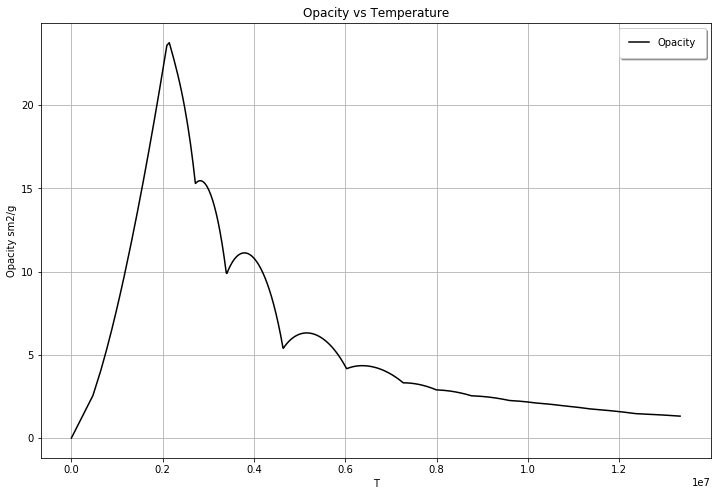

In [59]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
plt.plot(t, k, color='black', label='Opacity')
# plt.plot(r1, myk, color='red', marker='.', label='Непроз my')
#plt.xlim(6, 7.25)
#plt.ylim(0, 20)
plt.xlabel('T')
plt.ylabel('Opacity sm2/g')
plt.title('Opacity vs Temperature')
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);